In [ ]:
'''
1. データのダウンロード
'''
import os
import tensorflow as tf

# データセットのダウンロード
# Kaggle の Dogs vs Cats データセットをフィルタリングしたバージョンを使用
# データセットのアーカイブバージョンをダウンロードし、"/tmp/"ディレクトリに保存
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# 訓練および検証データのファイルパスを変数に格納
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
'''
2. ジェネレーターを生成し、画像を加工処理する
''' 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def ImageDataGenerate(train_dir, validation_dir):
    """画像を加工処理する
    
    Returns:
      train_generator(DirectoryIterator):
          訓練データのジェネレーター
      validation_generator(DirectoryIterator):
          検証データのジェネレーター
    """
    # データセットの前処理およびネットワークの学習中に使用する変数を設定
    batch_size = 32
    IMG_HEIGHT = 224
    IMG_WIDTH = 224

    # ジェネレーターの生成
    # 訓練データ
    train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        width_shift_range=0.1,
        height_shift_range=0.1
        )
    # 検証データ
    validation_image_generator = ImageDataGenerator(rescale=1./255)

    # flow_from_directory()メソッドでディスクから画像を読み込み、
    # リスケーリングを適用して画像を必要な大きさにリサイズ
    # 訓練データ
    train_data_gen = train_image_generator.flow_from_directory(
        batch_size=batch_size, # ミニバッチのサイズ
        directory=train_dir,   # 抽出先のディレクトリ
        shuffle=True,          # 抽出する際にシャッフルする
        target_size=(IMG_HEIGHT, IMG_WIDTH), # 画像をリサイズ
        class_mode='binary')   # 正解ラベルを0と1に変換

    # 検証データ
    val_data_gen = validation_image_generator.flow_from_directory(
        batch_size=batch_size, # ミニバッチのサイズ
        directory=validation_dir,   # 抽出先のディレクトリ
        target_size=(IMG_HEIGHT, IMG_WIDTH), # 画像をリサイズ
        class_mode='binary')   # 正解ラベルを0と1に変換
    
    # 生成した訓練データと検証データを返す
    return train_data_gen, val_data_gen

In [ ]:
'''
3. モデルを生成して学習を行う
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras import optimizers

def train_CNN(train_data_gen, val_data_gen):
    """CNNで学習する
    
    Returns:
      history(Historyオブジェクト)
    """
    # 画像のサイズを取得
    image_size = len(train_data_gen[0][0][0])
    # 入力データの形状をタプルにする
    input_shape = (image_size, image_size, 3)
    # ミニバッチのサイズを取得
    batch_size = len(train_data_gen[0][0])
    # 訓練データの数を取得(バッチの数×ミニバッチサイズ)
    total_train = len(train_data_gen)*batch_size
    # 検証データの数を取得(バッチの数×ミニバッチサイズ)
    total_validate = len(val_data_gen)*batch_size
    
    # モデルを構築
    model = Sequential()

    # （第1層）畳み込み層
    model.add(
        Conv2D(
            filters=32,                # フィルターの数は32
            kernel_size=(3, 3),        # 3×3のフィルターを使用
            input_shape=input_shape, # 入力データの形状
            padding='same',            # ゼロパディングを行う
            activation='relu'          # 活性化関数はReLU
            ))
    # （第2層）プーリング層
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    # ドロップアウト25％
    model.add(Dropout(0.25))

    # （第3層）畳み込み層
    model.add(
        Conv2D(
            filters=32,            # フィルターの数は32
            kernel_size=(3, 3),    # 3×3のフィルターを使用
            activation='relu'      # 活性化関数はReLU
            ))
    # （第4層）プーリング層
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    # ドロップアウト25％
    model.add(Dropout(0.25))

    # （第5層）畳み込み層
    model.add(
        Conv2D(filters=64,      # フィルターの数は64
            kernel_size=(3, 3), # 3×3のフィルターを使用
            activation='relu'   # 活性化関数はReLU
            ))
    # （第6層）プーリング層
    model.add(
        MaxPooling2D(pool_size=(2, 2)))
    # ドロップアウト25％
    model.add(Dropout(0.25))

    # Flatten層
    # 出力層への入力を4階テンソルから2階テンソルに変換する
    model.add(Flatten())

    # （第7層）全結合層
    model.add(
        Dense(64,                  # ニューロン数は64
            activation='relu'))  # 活性化関数はReLU
    # ドロップアウト50％
    model.add(Dropout(0.5))

    # （第8層）出力層
    model.add(
        Dense(
            1,                     # ニューロン数は1個
            activation='sigmoid')) # 活性化関数はsigmoid

    # モデルのコンパイル
    model.compile(
        loss='binary_crossentropy', # バイナリ用の交差エントロピー誤差
        metrics=['accuracy'],       # 学習評価として正解率を指定
        # Adamアルゴリズムで最適化
        optimizer=optimizers.Adam(),
    )

    # モデルのサマリを表示
    model.summary()

    # ファインチューニングモデルで学習する
    epochs = 60   # エポック数
    history = model.fit(
        # 訓練データ
        train_data_gen,
        # エポック数
        epochs=epochs,
        # 検証データ
        validation_data=val_data_gen,
        # 検証時のステップ数
        validation_steps=total_validate//batch_size,
        # 訓練時のステップ数
        steps_per_epoch=total_train//batch_size,
        # 学習の進捗状況を出力する    
        verbose=1
    )
    
    # historyを返す
    return history

In [ ]:
%%time
'''
4. 学習を行う
'''
# データジェネレーターを取得
train_data_gen, val_data_gen = ImageDataGenerate(train_dir, validation_dir)
# VGG16の出力をFCネットワークで学習
history = train_CNN(train_data_gen, val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 32)        0         
______________________________________

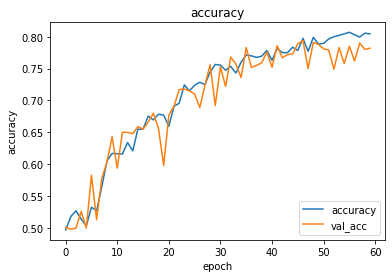

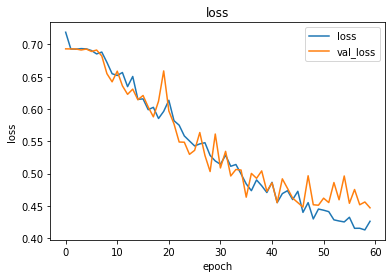

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)